In [1]:
import lmfit
import dask as dk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [199]:
def math_model(N: float):
    ''' Creates a semigaussian function with n order
    Returns
    -------
    function
        the mathematical semigaussian function with a specified N
    '''
    def crrcn(x, t0: float, amp: float, tau: float, offset: float, k: float, dt: float):
        crrcn = np.zeros(np.shape(x))
        for t in x:
            if t < t0:
                crrcn[t] = offset
            elif t0 <= t and t < t0 + dt:
                crrcn[t] = offset + amp * (np.exp(N) / (N ** N)) * ((t - t0) / tau) ** N * np.exp( - (t - t0) / tau) 
            elif t0 + dt <= t: 
                crrcn[t] = offset + amp * (np.exp(N) / (N ** N)) * ((t - t0) / tau) ** N * np.exp( - (t - t0) / tau) \
                    + k * amp * (np.exp(N) / (N ** N)) * ((t - (t0 + dt)) / tau) ** N * np.exp( - (t - (t0+ dt)) / tau)
        return crrcn
    return crrcn

In [200]:
def residual(pars, x, data):
    model = (gaussian(x, pars['amp_g'], pars['cen_g'], pars['wid_g']) +
             lorentzian(x, pars['amp_l'], pars['cen_l'], pars['wid_l']))
    return model - data

In [201]:
def residual_exp(pars, x, data):
    crrcn = math_model(3)
    model = crrcn(x, pars['t0'], pars['amp'], pars['tau'], pars['offset'], pars['k'], pars['dt'])
    return model - data

In [202]:
def create_model(N): 
    return lmfit.Model(math_model(N))

In [2]:
def make_parameters(model, params, bounds= None):
    if not bounds:
        bounds = {k:(-np.inf,np.inf) for k,_ in params.items()}
    pars = model.make_params()
    for (k,v), (_,v2) in zip(params.items(),bounds.items()):
        pars.add(name=k, value=v, min=v2[0], max=v2[1])
    return pars

In [204]:
def guess_parameters(model, x, y):
    # only for lmfit built-in modules
    return model.guess(y, x=x)

In [205]:
dat = np.loadtxt('data/filterb1015m7f.csv', delimiter=',')
dat.shape

OSError: data/filterb1015m7f.csv not found.

In [206]:
x = np.linspace(0,31,32, dtype= 'int16')

In [207]:
model = lmfit.Model(crrcn)

In [208]:
params ={'N':2,'t0':10, 'amp':120, 'tau':2, 'offset':50, 'k':0.2, 'dt':4}
bounds = {'N': (1.99,2.01),'t0':(-np.inf, np.inf), 'amp':(-np.inf, np.inf), 'tau':(-np.inf, np.inf), 'offset':(-np.inf, np.inf), 'k':(-np.inf, np.inf), 'dt':(-np.inf, np.inf)} #{'t0':(-15,10), 'amp':(0,4096), 'tau':(1,3), 'offset':(40,60), 'k':(0,0.6), 'dt':(4,9)}
pars = make_parameters(model, params, bounds)
pars

Parameters([('N', <Parameter 'N', value=2, bounds=[1.99:2.01]>),
            ('t0', <Parameter 't0', value=10, bounds=[-inf:inf]>),
            ('amp', <Parameter 'amp', value=120, bounds=[-inf:inf]>),
            ('tau', <Parameter 'tau', value=2, bounds=[-inf:inf]>),
            ('offset', <Parameter 'offset', value=50, bounds=[-inf:inf]>),
            ('k', <Parameter 'k', value=0.2, bounds=[-inf:inf]>),
            ('dt', <Parameter 'dt', value=4, bounds=[-inf:inf]>)])

In [209]:
d = dat[5][8:40]
out = model.fit(d, pars, x=x, method='powell')
plt.plot(x, d, 'b')
#plt.plot(x, init, 'k--', label='initial fit')
plt.plot(x, out.best_fit, 'r-', label='best fit')
plt.legend(loc='best')

NameError: name 'dat' is not defined

In [210]:
out.result

NameError: name 'out' is not defined

In [16]:
def crrcn(x, N: int, t0: float, amp: float, tau: float, offset: float, k: float, dt: float):
    crrcn = np.zeros(np.shape(x))
    for t in x:
        if t < t0:
            crrcn[t] = offset
        elif t0 <= t and t < t0 + dt:
            crrcn[t] = offset + amp * (np.exp(N) / (N ** N)) * ((t - t0) / tau) ** N * np.exp( - (t - t0) / tau) 
        elif t0 + dt <= t: 
            crrcn[t] = offset + amp * (np.exp(N) / (N ** N)) * ((t - t0) / tau) ** N * np.exp( - (t - t0) / tau) \
                + k * amp * (np.exp(N) / (N ** N)) * ((t - (t0 + dt)) / tau) ** N * np.exp( - (t - (t0+ dt)) / tau)
    return crrcn

In [212]:
results = []
for i in range(len(dat)):
    try:
        results.append(model.fit(dat[i][8:40], pars, x=x))
    except:
        print(i)
len(results)

NameError: name 'dat' is not defined

In [213]:
N = []; t0 = []; amp = []; tau = []; offset = []; k = []; dt = [] # all fitting params
chisqr = []; residuals = []
for i in results:
    if i.chisqr < 400:
        N.append(i.best_values['N'])
        t0.append(i.best_values['t0'])
        amp.append(i.best_values['amp'])
        tau.append(i.best_values['tau'])
        offset.append(i.best_values['offset'])
        k.append(i.best_values['k'])
        dt.append(i.best_values['dt'])
        chisqr.append(i.chisqr)
        residuals.append(i.residual)

In [214]:
best_params = {'N':np.mean(N), 
               't0':np.mean(t0), 
               'amp':np.mean(amp), 
               'tau':np.mean(tau), 
               'offset':np.mean(offset), 
               'k':np.mean(k), 
               'dt':np.mean(dt)}
best_params = make_parameters(model, best_params, bounds)
r = model.eval(params=best_params, x=x)
len(N)

c:\users\mlabadm\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


0

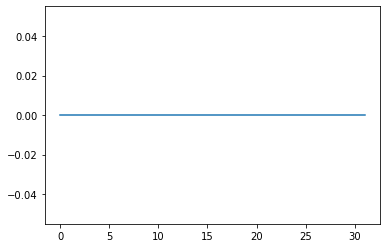

In [215]:
plt.plot(r)


In [44]:
def W(x, rt: int, zt: int, ft: int): # output expected shape
    W = np.zeros(np.shape(x))
    for t in x:
        if t <= zt:
            W[t] = 0 
        elif t <= zt + rt:
            W[t] = (t - zt)*(1/rt)
        elif t < zt + rt + ft:
            W[t] = 1
        elif t < zt + 2*rt + ft: 
            W[t] = 1 + (zt + rt + ft - t)*(1/rt)
        else:
            W[t] = 0
    return W

In [146]:
def filter_optimization(coeff: dict, params_args:dict, m_params: list) :
    ''' DPLMS optimization for FIR filter
    Takes the best parameters of the fitting and the noise autocorrelation function 
    to optimize the parameters of the filter using penalizied least means squares
    best_params = [t0, amp, tau, offset, k, dt, chisqr]
    '''
    model = lmfit.Model(crrcn)
    params_args['S'] = model.eval(x=np.arange(150), params= make_parameters(model, m_params))
    params_args['W'] = params_args.pop('Wamp') * W(np.arange(150), params_args['rt'], params_args.pop('zt') + params_args['ta'], params_args['ft'])
    method = params_args.pop('method', 'leastsq')
    p_true = lmfit.Parameters()
    for k, v in coeff.items():
        p_true.add(k, value=v, min=-1, max=1)
    fir_obj = lmfit.minimize(cost_function, p_true, kws=params_args, method='NelderMead')
    coef = []
    for _, param in fir_obj.params.items():
        coef.append(param.value)
    return fir_obj, coef, np.correlate(params_args['S'], coef,'same')

In [147]:
def cost_function(pars, a1: float, a2: float, a3: float, a0: float, rt: float, ta: float, ft: float, acf: list, S: list, W: list):
    vals = pars.valuesdict()
    c = list(vals.values())
    s0 = 0; s1 = 0; s2 = 0; s2a = 0 ;s3 = 0 
    s0 = np.sum(c)**2                           # Mean zero
    s1 = np.sum(c * np.arange(0, len(c)))**2      # ramp inmunity
    fir = np.correlate(S, c, 'same')
    s2 = np.sum(np.power(fir[ta+rt:ta+rt+ft] - W[ta+rt:ta+rt+ft],2))
    for i in range(len(c)):                     # Signal to Noise ratio optimization
        for j in range(len(c)):
            s3 +=c[i]*c[j]*acf[abs(i-j)]
    #for j in range(rt, rt + ft - 1):           # Flat-top restriction
    #    s2 += s2a**2
    #    for i in range(len(c)):
    #        s2a += c[i] * S[len(c)+j-i] - 1
    return a0*s0 + a1*s1 + a2*s2 + a3*s3

In [148]:
coef1 = [0.0476057,0.0471349,0.0462363,0.0449495,0.0433123,0.0413583,0.0391185,0.0366223,0.0338967,0.0309671,0.0278571,0.0245881,0.0211801,0.0176521,0.0140208,0.0103032,0.00651459,0.00267206,-0.00121062,-0.00511842,-0.00903791,-0.012954,-0.0168527,-0.0207217,-0.0245455,-0.02831,-0.032,-0.0355993,-0.0390901,-0.0424544,-0.0456736,-0.0487289,-0.0515975,-0.0542545,-0.056676,-0.0588339,-0.0606986,-0.0622394,-0.0634183,-0.0642001,-0.0645449,-0.0644058,-0.0637351,-0.0624819,-0.0605909,-0.0580016,-0.0546472,-0.0504559,-0.0453516,-0.0392511,-0.0320633,-0.0236915,-0.0140378,-0.00298854,0.00957617,0.0237861,0.0258992,0.0244942,0.0251363,0.0252156,0.0243508,0.026278,0.0228656,0.0280651,0.0434962,0.0472542,0.0435143,0.0354418,0.0253926,0.0150604,0.00562615,-0.00214955,-0.00782631,-0.0112045,-0.0122711,-0.0111444,-0.00803251,-0.00321619,0.00301425,0.0103338,0.0184225,0.0269607,0.035656,0.0442475,0.0524933,0.0601785,0.0671225,0.0731726,0.0782159,0.0821642,0.0849483,0.0865392,0.0869078,0.086066,0.0840216,0.0808233,0.0765288,0.0711951,0.064901,0.0577217,0.0497416,0.0410633,0.0317861,0.0220238,0.0118652,0.00143216,-0.00915519,-0.0197845,-0.0303515,-0.040733,-0.0508125,-0.0604744,-0.0695932,-0.0780467,-0.0857026,-0.0924245,-0.0980824,-0.102546,-0.105667,-0.107307]

In [149]:
coeff_len = 30
#              N, t0, amp, tau, offset, k, dt
best_params = [2,30,1000 ,7.81,100,0.2,31]
coeff = dict(zip([f'c{N}' for N in range(coeff_len)], coef1[:coeff_len]))
alf_dict = dict(zip([f'a{N}' for N in range(4)],[1000,0.0,100,0.0]))
acf_dict = {'acf': [1]+[0]*(len(coeff) - 1)}
pars_dict = {'rt':20,'ft':9, 'zt': 0, 'ta': best_params[1], 'Wamp': best_params[2]}
params_args = {**alf_dict, **acf_dict, **pars_dict}
pars_name= ['N', 't0', 'amp', 'tau', 'offset', 'k', 'dt']
model_params = dict(zip(pars_name,best_params))

In [150]:
fir_obj, coef, conv = filter_optimization(coeff, params_args, model_params)
fir_obj

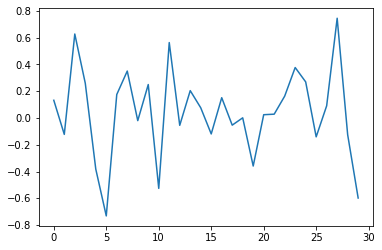

In [151]:
plt.plot(coef)

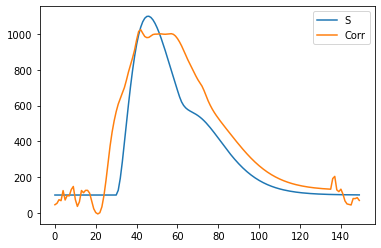

In [156]:
W_plot = 1000*W(np.arange(150), pars_dict['rt'], pars_dict['zt'] + pars_dict['ta'], pars_dict['ft'])
model = lmfit.Model(crrcn)
plt.plot(model.eval(x=np.arange(150), params= make_parameters(model, model_params)), label='S')  # Plot some data on the axes.
#plt.plot(W_plot, label='W')  # Plot more data on the axes...
plt.plot(conv, label= 'Corr')
plt.legend()

In [153]:
print(np.max(conv), np.argmax(conv))

1024.297440552191 42


In [154]:
coef1 = [0.0476057,0.0471349,0.0462363,0.0449495,0.0433123,0.0413583,0.0391185,0.0366223,0.0338967,0.0309671,0.0278571,0.0245881,0.0211801,0.0176521,0.0140208,0.0103032,0.00651459,0.00267206,-0.00121062,-0.00511842,-0.00903791,-0.012954,-0.0168527,-0.0207217,-0.0245455,-0.02831,-0.032,-0.0355993,-0.0390901,-0.0424544,-0.0456736,-0.0487289,-0.0515975,-0.0542545,-0.056676,-0.0588339,-0.0606986,-0.0622394,-0.0634183,-0.0642001,-0.0645449,-0.0644058,-0.0637351,-0.0624819,-0.0605909,-0.0580016,-0.0546472,-0.0504559,-0.0453516,-0.0392511,-0.0320633,-0.0236915,-0.0140378,-0.00298854,0.00957617,0.0237861,0.0258992,0.0244942,0.0251363,0.0252156,0.0243508,0.026278,0.0228656,0.0280651,0.0434962,0.0472542,0.0435143,0.0354418,0.0253926,0.0150604,0.00562615,-0.00214955,-0.00782631,-0.0112045,-0.0122711,-0.0111444,-0.00803251,-0.00321619,0.00301425,0.0103338,0.0184225,0.0269607,0.035656,0.0442475,0.0524933,0.0601785,0.0671225,0.0731726,0.0782159,0.0821642,0.0849483,0.0865392,0.0869078,0.086066,0.0840216,0.0808233,0.0765288,0.0711951,0.064901,0.0577217,0.0497416,0.0410633,0.0317861,0.0220238,0.0118652,0.00143216,-0.00915519,-0.0197845,-0.0303515,-0.040733,-0.0508125,-0.0604744,-0.0695932,-0.0780467,-0.0857026,-0.0924245,-0.0980824,-0.102546,-0.105667,-0.107307]

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])